# Hydraulic Model

In [4]:
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns
import pandas as pd

import json
from tqdm import tqdm

from sklearn.metrics import root_mean_squared_error

from itertools import permutations

# import function from another jupyter notebook
import import_ipynb
import Function_simple
import Function_error

### Inputs

In [2]:
h_b = -1*np.arange(10,15010+100,100, dtype=int) #bulk soil water potential in cm heads
E = 3e-6*np.arange(0,3000+1,1) #transpiration rate in cm3 s**-1

In [3]:
with open('../2_Data/1_SoilData/soil_Data.json') as f:
    soil_Data = json.load(f)

In [4]:
soil_types_interested = ["Clay", "Silt Loam", "Sandy Loam"]
soil_Data = {soil: soil_Data[soil] for soil in soil_types_interested}

### Heatmap Computation

Compute the Hydraulic Model for every paramter combination and store it in a dictionary

In [7]:
# Define ranges and sampling resolution
n_vals = 7

R_root_vals = np.linspace(0.06e7, 0.15e7, n_vals) # A
h0_x_vals = np.linspace(-28000, -16000, n_vals) # B
tau_x_vals = np.linspace(3, 9, n_vals) # C

# Create meshgrid
A, B, C = np.meshgrid(R_root_vals, h0_x_vals, tau_x_vals, indexing='ij')

# where A = R_root; B = h0_x; C = tau_x

# Flatten and combine into a list of triplets
triplets = np.stack([A.ravel(), B.ravel(), C.ravel()], axis=-1)

# Store in a DataFrame
df = pd.DataFrame(triplets, columns=["A", "B", "C"])

In [8]:
df

,A,B,C
0,600000.0,-28000.0,3.0
1,600000.0,-28000.0,4.0
2,600000.0,-28000.0,5.0
3,600000.0,-28000.0,6.0
4,600000.0,-28000.0,7.0
...,...,...,...
338,1500000.0,-16000.0,5.0
339,1500000.0,-16000.0,6.0
340,1500000.0,-16000.0,7.0
341,1500000.0,-16000.0,8.0


In [ ]:
# Evaluate model at triplet values
tqdm.pandas()

df["model_output"] = df.progress_apply(lambda row: Function_simple.Calc_SOL(E, h_b, [row["A"], row["B"], row["C"]]), axis=1)

  0%|          | 0/343 [00:00<?, ?it/s]

100%|██████████| 343/343 [00:10<00:00, 31.92it/s]


In [10]:
#df.to_json(f"../2_Data/Heatmaps/heatmap_data_SOL_Rrootfix0.1_newrange.json", orient="split", compression='infer', index=True)

In [11]:
#df = pd.read_json(f"../2_Data/Heatmaps/heatmap_data_SOL.json", orient='split', compression='infer')
#df['model_output'] = df['model_output'].apply(np.array)

In [ ]:
#df

,A,B,C,model_output
0,600000.0,-28000.0,3.0,"[[-10.0, -5445.670506113931, 0.008994], [-110...."
1,600000.0,-28000.0,4.0,"[[-10.0, -5413.921630709316, 0.008994], [-110...."
2,600000.0,-28000.0,5.0,"[[-10.0, -5407.84925843517, 0.008994], [-110.0..."
3,600000.0,-28000.0,6.0,"[[-10.0, -5406.679687070955, 0.008994], [-110...."
4,600000.0,-28000.0,7.0,"[[-10.0, -5406.453997085155, 0.008994], [-110...."
...,...,...,...,...
338,1500000.0,-16000.0,5.0,"[[-10.0, -9483.447892253433, 0.005943], [-110...."
339,1500000.0,-16000.0,6.0,"[[-10.0, -10077.302921591992, 0.006372], [-110..."
340,1500000.0,-16000.0,7.0,"[[-10.0, -10557.024018468708, 0.00672], [-110...."
341,1500000.0,-16000.0,8.0,"[[-10.0, -10958.692221985882, 0.007011], [-110..."


Compute RMSE

In [ ]:
heatmaps = {}

for i, soil in enumerate(soil_Data):
    df_heat = df.copy()
    
    data_SOL = np.array(soil_Data[soil]["traject"])

    df_heat['error'] = df_heat.apply(lambda row: Function_error.calc_error(row["model_output"], data_SOL), axis=1)
    df_heat = df_heat.drop('model_output', axis=1)

    heatmaps[soil] = df_heat

#### Plotting

In [13]:
def round_to_2sig(x):
    if x == 0:
        return 0
    else:
        return round(x, -int(np.floor(np.log10(abs(x)))) + 1)

In [14]:
# Define formatting function
def sci_formatter(x):
    return f'{x:.2e}'

In [15]:
# Get consistent color range
min = [heatmaps[soil]["error"].min() for soil in soil_types_interested]
max = [heatmaps[soil]["error"].max() for soil in soil_types_interested]

vmin = np.min(min)
vmax = np.max(max)

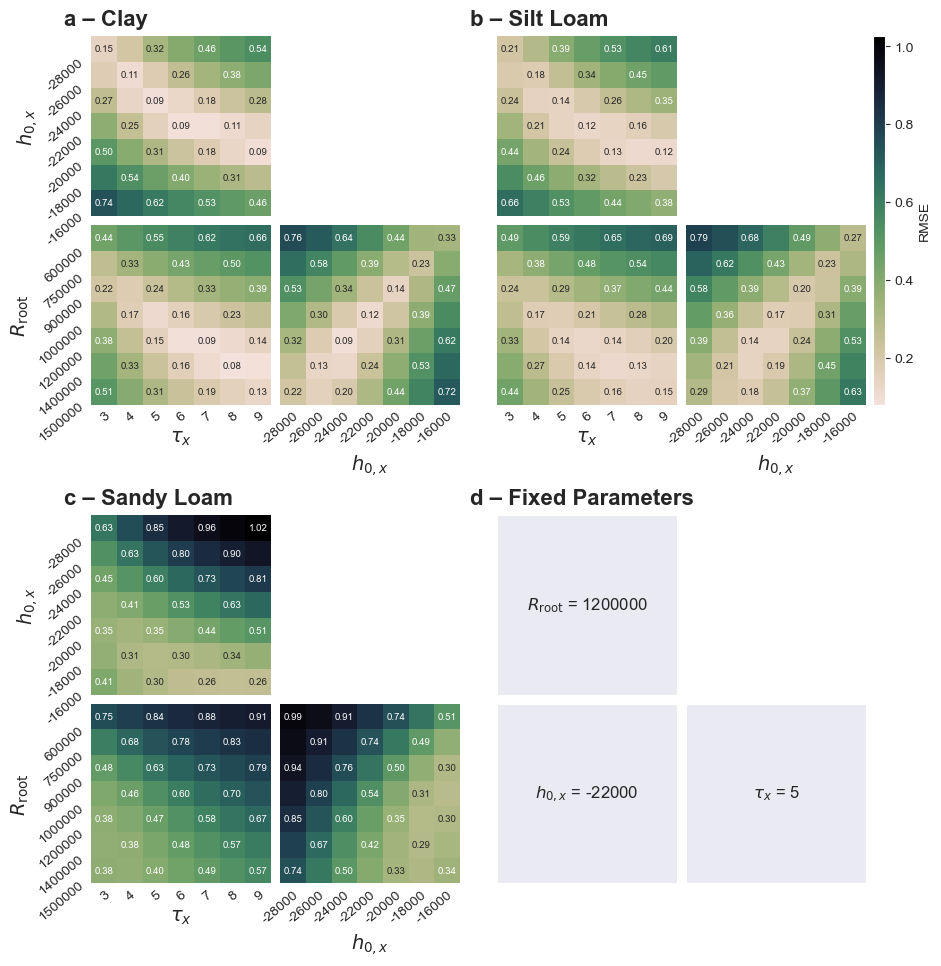

In [16]:
# Plot heatmap
sns.set_style('darkgrid')

cmap_heat = sns.cubehelix_palette(start=0.1, rot=-.75, light=0.9, dark=0., as_cmap=True)
#cmap_heat =  sns.cubehelix_palette(start=.5, rot=1.5, light=.75, dark=0.2, as_cmap=True) # colormap

fontsize=14

labels = ['a', 'b', 'c']
variables = ['A', 'B', 'C']
vars_names = {
    'A': r'$R_{\text{root}}$',
    'B': r'$h_{0,x}$',
    'C': r'$\tau_x$'
    }

combinations = [(x, y, z) for x, y, z in permutations(variables, 3) if len({x, y, z}) == 3]
combinations = [combinations[0], combinations[2], combinations[4]]

# define fixed values
R_root_fixed = 1200000
h0_x_fixed = -22000
tau_x_fixed = 5

vars_fixed = [R_root_fixed, h0_x_fixed, tau_x_fixed]

fig = plt.figure(figsize=(10, 11))
outer = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.3)

for i, soil in enumerate(heatmaps):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[i], wspace=0.05, hspace=0.05)

    df_soil = heatmaps[soil]

    for j, comb in enumerate(combinations):
        if j == 0:
            j_pos = j
        else:
            j_pos = j+1

        ax = plt.Subplot(fig, inner[j_pos])
        
        #ax = plt.subplot(2, 2, i_pos + 1)

        subset = df_soil[np.isclose(df[comb[0]], vars_fixed[j])]
        heatmap_subset = subset.pivot(index=comb[1], columns=comb[2], values="error")
        mask = heatmap_subset.isna()

        # Create annotation matrix
        annot = np.full(heatmap_subset.shape, "", dtype=object)

        # Fill every second element (e.g., checkerboard pattern)
        for k in range(heatmap_subset.shape[0]):
            for v in range(heatmap_subset.shape[1]):
                if (k + v) % 2 == 0:  # or use other conditions
                    val = heatmap_subset.iloc[k, v]
                    annot[k, v] = f"{val:.2f}"

        heatmap = sns.heatmap(heatmap_subset, cmap=cmap_heat, vmin=vmin, vmax=vmax, ax=ax, cbar=False, fmt='', annot=annot, annot_kws={"fontsize": 7}, mask=mask)

        ax.set_box_aspect(1) # make subplots quadratic

        cmap_heat.set_bad(color='gray')  # Color for NaNs

        # Mask NaNs for plotting
        masked_data = np.ma.masked_invalid(heatmap_subset)
        
        img = ax.imshow(masked_data, cmap=cmap_heat)

        # Set rounded axis ticks to 2 decimal places
        if vars_names[comb[2]] == r'$\tau_x$':
            type_xticks = np.float64
        else:
            type_xticks = np.int64

        type_xticks = np.int64 # make all tickes integers
        
        xticks = np.array([round_to_2sig(val) for val in heatmap_subset.columns.values.astype(type_xticks)])
        yticks = np.array([round_to_2sig(val) for val in heatmap_subset.index.values.astype(np.int64)])

        ax.set_xticks(np.arange(len(xticks)) + 0.8)
        ax.set_yticks(np.arange(len(yticks)) + 0.8)
        ax.set_xticklabels(xticks, rotation=40, ha='right')
        ax.set_yticklabels(yticks, rotation=40, va='top')

        ax.tick_params(pad=0.2)

        #ax.set_title(f"{vars_names[comb[0]]} = {vars_fixed[j]}", fontsize=fontsize)
        ax.set_xlabel(vars_names[comb[2]], fontsize=fontsize)
        ax.set_ylabel(vars_names[comb[1]], fontsize=fontsize)

        if j == 0:
            ax.set_xticks([])
            ax.set_xlabel("")
            ax.text(-0.15, 1.15, f'{labels[i]} – {soil}', transform=ax.transAxes, fontsize=fontsize+2, va='top', ha='left', weight='bold') # add label a), b), or c)
        
        if j == 2: 
            ax.set_yticks([])
            ax.set_ylabel("")

        if i == 1:
            ax.set_yticks([])
            ax.set_ylabel("")

        #if i == 0:
            #ax.set_xticks([])
            #ax.set_xlabel("")

        fig.add_subplot(ax)

# Add empty plot as explanation
inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[3], wspace=0.05, hspace=0.05)

for n, vars in enumerate(vars_fixed):
    if n == 0:
            n_pos = n
    else:
        n_pos = n + 1

    ax_empty = plt.Subplot(fig, inner[n_pos])
    ax_empty.text(0.5, 0.5, f"{vars_names[combinations[0][n]]} = {vars_fixed[n]}", fontsize=fontsize-2, va='center', ha='center')
    
    ax_empty.set_xticks([])
    ax_empty.set_yticks([])

    if n == 0:
        ax_empty.text(-0.15, 1.15, 'd – Fixed Parameters', transform=ax_empty.transAxes, fontsize=fontsize+2, va='top', ha='left', weight='bold') # add label a), b), or c)

    fig.add_subplot(ax_empty)

# Add single shared colorbar

ax_1 = plt.Subplot(fig, outer[1])

axins = inset_axes(ax_1, # here using axis of the lowest plot
               width="3%",  # width = 5% of parent_bbox width
               height="100%",  # height : 340% good for a (4x4) Grid
               loc='lower left',
               bbox_to_anchor=(1.02, 0.0, 1, 1),
               bbox_transform=ax_1.transAxes,
               borderpad=0,
               )

cbar = fig.colorbar(heatmap.get_children()[0], cax=axins, orientation="vertical", location='right')
cbar.set_label("RMSE")

#plt.tight_layout()
plt.savefig(f'heatmap_total.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
"""# Plot heatmap for plots with fixed R_root
sns.set_style('darkgrid')

cmap_heat = sns.cubehelix_palette(start=0.1, rot=-.75, light=0.8, dark=0., as_cmap=True)
#cmap_heat =  sns.cubehelix_palette(start=.5, rot=1.5, light=.75, dark=0.2, as_cmap=True) # colormap

fontsize=14

labels = ['a', 'b', 'c']
variables = ['A', 'B']
vars_names = {
    'A': r'$h_{0,x}$',
    'B': r'$\tau_x$'
    }

fig = plt.figure(figsize=(9, 10))

for i, soil in enumerate(heatmaps):

    df_soil = heatmaps[soil]

    ax = plt.subplot(2, 2, i+1)

    heatmap_subset = df_soil.pivot(index="A", columns="B", values="error")
    mask = heatmap_subset.isna()

    # Create annotation matrix
    annot = np.full(heatmap_subset.shape, "", dtype=object)

    # Fill every second element (e.g., checkerboard pattern)
    for k in range(heatmap_subset.shape[0]):
        for v in range(heatmap_subset.shape[1]):
            if (k + v) % 2 == 0:  # or use other conditions
                val = heatmap_subset.iloc[k, v]
                annot[k, v] = f"{val:.2f}"

    heatmap = sns.heatmap(heatmap_subset, cmap=cmap_heat, vmin=vmin, vmax=vmax, ax=ax, cbar=False, annot=annot, fmt="", annot_kws={"fontsize": 7}, mask=mask)

    ax.set_box_aspect(1) # make subplots quadratic

    cmap_heat.set_bad(color='gray')  # Color for NaNs

    # Mask NaNs for plotting
    masked_data = np.ma.masked_invalid(heatmap_subset)
    
    img = ax.imshow(masked_data, cmap=cmap_heat)

    # Set rounded axis ticks to 2 decimal places
    type_xticks = np.float64
    
    xticks = [round_to_2sig(val) for val in heatmap_subset.columns.values.astype(type_xticks)]
    yticks = [round_to_2sig(val) for val in heatmap_subset.index.values.astype(np.int64)]
    ax.set_xticks(np.arange(len(xticks)) + 0.5)
    ax.set_yticks(np.arange(len(yticks)) + 0.5)
    ax.set_xticklabels(xticks, rotation=40, ha='right')
    ax.set_yticklabels(yticks, rotation=40, va='top')

    #ax.tick_params(axis='x', pad=-0.5)

    #ax.set_title(f"{vars_names[comb[0]]} = {vars_fixed[j]}", fontsize=fontsize)
    ax.set_xlabel(vars_names["B"], fontsize=fontsize)
    ax.set_ylabel(vars_names["A"], fontsize=fontsize)

    ax.text(-0.15, 1.1, f'{labels[i]} – {soil}', transform=ax.transAxes, fontsize=fontsize+2, va='top', ha='left', weight='bold') # add label a), b), or c)

    if i == 1:
        ax.set_yticks([])
        ax.set_ylabel("")

    # Add single shared colorbar
    if i == 2:
        axins = inset_axes(ax, # here using axis of the lowest plot
               width="3%",  # width = 5% of parent_bbox width
               height="100%",  # height : 340% good for a (4x4) Grid
               loc='lower left',
               bbox_to_anchor=(1.02, 0.0, 1, 1),
               bbox_transform=ax.transAxes,
               borderpad=0,
               )

        cbar = fig.colorbar(heatmap.get_children()[0], cax=axins, orientation="vertical", location='right')
        cbar.set_label("RMSE")

    fig.add_subplot(ax)

#plt.tight_layout()
plt.savefig(f'heatmap_total.png', dpi=300, bbox_inches='tight')
plt.show()"""

'# Plot heatmap for plots with fixed R_root\nsns.set_style(\'darkgrid\')\n\ncmap_heat = sns.cubehelix_palette(start=0.1, rot=-.75, light=0.8, dark=0., as_cmap=True)\n#cmap_heat =  sns.cubehelix_palette(start=.5, rot=1.5, light=.75, dark=0.2, as_cmap=True) # colormap\n\nfontsize=14\n\nlabels = [\'a\', \'b\', \'c\']\nvariables = [\'A\', \'B\']\nvars_names = {\n    \'A\': r\'$h_{0,x}$\',\n    \'B\': r\'$\tau_x$\'\n    }\n\nfig = plt.figure(figsize=(9, 10))\n\nfor i, soil in enumerate(heatmaps):\n\n    df_soil = heatmaps[soil]\n\n    ax = plt.subplot(2, 2, i+1)\n\n    heatmap_subset = df_soil.pivot(index="A", columns="B", values="error")\n    mask = heatmap_subset.isna()\n\n    # Create annotation matrix\n    annot = np.full(heatmap_subset.shape, "", dtype=object)\n\n    # Fill every second element (e.g., checkerboard pattern)\n    for k in range(heatmap_subset.shape[0]):\n        for v in range(heatmap_subset.shape[1]):\n            if (k + v) % 2 == 0:  # or use other conditions\n       

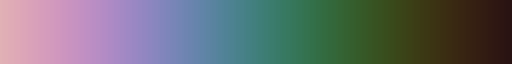

In [236]:
cmap_heat = sns.cubehelix_palette(start=0.5, rot=1.5, light=.75, dark=0.1, as_cmap=True) # colormap
cmap_heat